ではpytorchでも実装していきましょう。pytorchでは自前で配列を用意する必要があります。

In [1]:
import os
import numpy as np
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optimizers
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split

In [2]:
np.random.seed(0)
torch.manual_seed(0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
class DNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.l1 = nn.Linear(input_dim, hidden_dim)
        self.a1 = nn.ReLU()
        self.d1 = nn.Dropout(0.5)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.a2 = nn.ReLU()
        self.d2 = nn.Dropout(0.5)
        self.l3 = nn.Linear(hidden_dim, hidden_dim)
        self.a3 = nn.ReLU()
        self.d3 = nn.Dropout(0.5)
        self.l4 = nn.Linear(hidden_dim, output_dim)
        
        self.layers = [self.l1, self.a1, self.d1,
                       self.l2, self.a2, self.d2,
                       self.l3, self.a3, self.d3,
                       self.l4]
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            
        return x

最後に各出力を確率に落とし込むためにnn.sigmoidやnn.softmaxを挟む必要性がありそうに感じますが、実際には必要ありません。<br>
今回、損失関数としてnn.CrossEntropyLoss()を使用しますが、この関数の中では実際には二つの関数が動いており、<br>
nn.LogSoftmax(x)　　　ソフトマックス関数の対数を計算  $\log(softmax({\bf x})_i) = x_i - \log \sum_{j=1}^n \exp\{{x_j}\}$<br>
nn.NLLLoss(x, t)　　　負の対数尤度を計算　　　　　　　　　 $-\{t_i(\log(x_i))+(1-t_i)(\log(1-x_i))\} $

In [4]:
model = DNN(784, 200, 10).to(device)

In [5]:
root = os.path.join('~', '.torch', 'mnist')
transform = transforms.Compose([transforms.ToTensor(),
                               lambda x: x.view(-1)])
mnist_train = datasets.MNIST(root = root, 
                            download = True,
                            train = True,
                            transform = transform)
mnist_test = datasets.MNIST(root = root, 
                            download = True,
                            train = False,
                            transform = transform)

n_samples = len(mnist_train)
n_train = int(n_samples * 0.8)
n_val = n_samples - n_train

mnist_train, mnist_val = random_split(mnist_train, [n_train, n_val])

train_dataloader = DataLoader(mnist_train,
                             batch_size=100,
                             shuffle = True)
val_dataloader   = DataLoader(mnist_val,
                             batch_size=100,
                             shuffle =False)
test_dataloader  = DataLoader(mnist_test,
                             batch_size=100,
                             shuffle = False)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optimizers.SGD(model.parameters(), lr=0.01)
def compute_loss(t, y):
    return criterion(y, t)
def train_step(x, t):
    model.train()
    preds = model(x)
    loss = compute_loss(t, preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss, preds
def val_step(x, t):
    model.eval()
    preds = model(x)
    loss = criterion(preds, t)
    return loss, preds

epochs = 100
hist = {'val_loss': [], 'val_accuracy': []}
for epoch in range(epochs):
    train_loss = 0.
    train_acc  = 0.
    val_loss   = 0.
    val_acc    = 0.
    for (x, t) in train_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = train_step(x, t)
        train_loss += loss.item()
        train_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())
    train_loss /= len(train_dataloader)
    train_acc  /= len(train_dataloader)
    
    for (x, t) in val_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = val_step(x, t)
        val_loss += loss.item()
        val_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())
    val_loss /= len(val_dataloader)
    val_acc  /= len(val_dataloader)
    hist['val_loss'].append(val_loss)
    hist['val_accuracy'].append(val_acc)
    print('epoch: {}, loss: {:.3}, acc: {:.3f}, val_loss: {:.3}, val_acc: {:.3f}'.format(
                epoch+1,
                train_loss,
                train_acc,
                val_loss,
                val_acc))

epoch: 1, loss: 2.29, acc: 0.134, val_loss: 2.27, val_acc: 0.298250
epoch: 2, loss: 2.23, acc: 0.257, val_loss: 2.11, val_acc: 0.435667
epoch: 3, loss: 1.88, acc: 0.401, val_loss: 1.35, val_acc: 0.624333
epoch: 4, loss: 1.3, acc: 0.556, val_loss: 0.864, val_acc: 0.739833
epoch: 5, loss: 0.999, acc: 0.666, val_loss: 0.669, val_acc: 0.801750
epoch: 6, loss: 0.833, acc: 0.730, val_loss: 0.553, val_acc: 0.839750
epoch: 7, loss: 0.722, acc: 0.772, val_loss: 0.481, val_acc: 0.858833
epoch: 8, loss: 0.647, acc: 0.800, val_loss: 0.431, val_acc: 0.878667
epoch: 9, loss: 0.589, acc: 0.822, val_loss: 0.388, val_acc: 0.888583
epoch: 10, loss: 0.547, acc: 0.836, val_loss: 0.359, val_acc: 0.898250
epoch: 11, loss: 0.506, acc: 0.851, val_loss: 0.335, val_acc: 0.902250
epoch: 12, loss: 0.481, acc: 0.860, val_loss: 0.317, val_acc: 0.908750
epoch: 13, loss: 0.453, acc: 0.868, val_loss: 0.296, val_acc: 0.916000
epoch: 14, loss: 0.429, acc: 0.877, val_loss: 0.282, val_acc: 0.918583
epoch: 15, loss: 0.411,

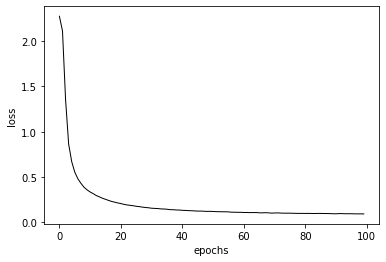

test_loss:0.154, test_acc:0.955


In [12]:
import matplotlib.pyplot as plt
val_loss = hist['val_loss']
fig = plt.figure()
plt.plot(range(len(val_loss)), val_loss, color='black', linewidth=1)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
def test_step(x, t):
    return val_step(x, t)

test_loss = 0.
test_acc = 0.
for (x, t) in test_dataloader:
    x, t = x.to(device), t.to(device)
    loss, preds = train_step(x, t)
    test_loss += loss.item()
    test_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())
test_loss /= len(test_dataloader)
test_acc /= len(test_dataloader)
print('test_loss:{:.3f}, test_acc:{:.3f}'.format(test_loss, test_acc))